# Two Intervals Around the Current Price
This strategy aims to fix the problem of having leftover liquidity. The first interval is the same as in the interval around the current price strategy 4.4, namely [pc − a, pc + a]. Let b be a paramter and b ∈ [10, 1000], then the second interval will either be [pc, pc +b] or [pc −b, pc], depending on which asset is leftover [4]. This will allow us to use up all our liquidity.

Import code dependencies

In [1]:
from typing import List

import matplotlib.dates as mdates
import pandas as pd
from matplotlib.pylab import plt

from demeter import MarketInfo
from demeter.broker import AccountStatus
from demeter.result import performance_metrics

Set matplotlib to show formatted account status

In [2]:
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

Make plot about price and account value / position net value

In [3]:
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

Add dependence about run Actuator

In [4]:
from datetime import timedelta, date
import pandas as pd

from demeter import TokenInfo, Actuator, ChainType, MarketInfo, Strategy, PeriodTrigger, RowData
from demeter.uniswap import UniV3Pool, UniLpMarket

Set pandas output format

In [5]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Two Intervals Around the Current Price strategy with code to add liquidity at constant interval around current price.

In [6]:
class TwoIntervalsAroundtheCurrentPriceStrategy(Strategy):
    def __init__(self, a=10, b=1, update_interval=timedelta(days=1)):
        super().__init__()
        self.a = a
        self.b = b

    def initialize(self):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        init_price = lp_market.market_status.data.price

        lp_market.add_liquidity(init_price - self.a, init_price + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(init_price - self.b, init_price)
        else:
            lp_market.add_liquidity(init_price, init_price + self.b)
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]

        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])

        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(row_data.prices[eth.name] - self.b, row_data.prices[eth.name])
        else:
            lp_market.add_liquidity(row_data.prices[eth.name], row_data.prices[eth.name] + row_data.prices[eth.name] + self.b)


Main logic to run Actuator, init two token and market with key "market1"

In [7]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("market1")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = TwoIntervalsAroundtheCurrentPriceStrategy(400, 200)

market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 13), date(2023, 8, 17))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2024-10-05 04:45:11,856 - INFO - start load files from 2023-08-13 to 2023-08-17...
2024-10-05 04:45:11,897 - INFO - load file complete, preparing...
2024-10-05 04:45:11,973 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [8]:
actuator.run()
print({k: round(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})

actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)

2024-10-05 04:45:12,760 - INFO - Qute token is USDC
2024-10-05 04:45:12,761 - INFO - init strategy...
2024-10-05 04:45:12,763 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 9789.19it/s]
2024-10-05 04:45:13,513 - INFO - main loop finished
2024-10-05 04:45:13,588 - INFO - Print actuator summary
2024-10-05 04:45:13,605 - INFO - Backtesting finished, execute time 0.8450901508331299s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.54842149               
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1        liquidity
0      201330      202500  3.1950444  0.0020644004  410299414876176

Quote by: USDC
Account balance history                           
l1                  net_value tokens              market1                                                                                          price     
l2                              USDC        ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00      2000   2000          0         0                0                 0                0        

TypeError: type Timestamp doesn't define __round__ method

Make plot about output net value、value in position、value in account and price

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_75893/242916292.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


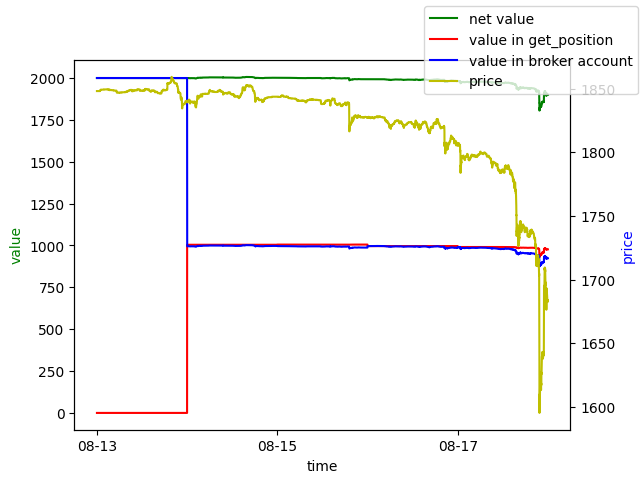

In [9]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)